# Data readin & setup

In [490]:
# installs
#!pip install scikit-learn
# !pip install imblearn
# !pip install keras
# %pip install tensorflow
# %pip install plotly
# %pip install --upgrade nbformat
# CONSIDER: tomek links & appropriateness of stdscaler

In [ ]:
# Importsimport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import math
import seaborn as sns

from itertools import chain
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import plotly.graph_objects as go

import tensorflow as tf

#sklearn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,  auc, confusion_matrix, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score
from sklearn.utils.class_weight import compute_class_weight


#keras related imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution1D, Reshape
from keras import optimizers, initializers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers




In [ ]:
df = pd.read_csv('muontracks.csv')
signal_pdg_codes = [511,521,531,541]     # Full Signal Options [411,421,431,4122,4132,4232,511,521,531,541,5122,5132,5232] 
keep_pdg_codes = [211,321,411,421,431,511,521,531,541]# Pions, kaons, B & D[211,321,411,421,431,511,521,531,541] # all pdgs to keep

# quick cut of all the high PDG codes to see if this alters matters   No Significant difference
df = df[ (df['chi2'] <= 10) & (df['chi2']>0) ]                     # Clear out some of the garbage chi2 entries
df = df[ (df['trackType'] == 3)]                                    # Only do tracktype3 the mchmid matches, then ditch column
df = df[ (df['p'] > 4)]                                             #pt cut below 0.5 or p below 4since anything below that's nonphysical (not detected in ALICE)
df = df[ (df['pt'] > 0.5)]
df = df[ (df['eta'] <= -2.5) & (df['eta']>-4) ]                     # geometric filtering
df = df[ (df['rabs'] > 17.6) & (df['rabs']<89.5) ] 
df['signal'] = df['motherPDG'].isin(signal_pdg_codes).astype(int)   # Setup Signal column
df = df[df['motherPDG'].isin(keep_pdg_codes)] # Drop all non sanctioned PDG codes


df = df.drop(columns=['trackType','mcID','trackID','collisionID','motherPDG']) # Drop columns unsuitable for training
df = df.drop(columns=['chi2MatchMCHMID','nClusters','isPrompt']) # Drop columns deemed useless 'chi2MatchMCHMID','nClusters','eta','phi','chi2','pDca','isPrompt'
# Wonder if we can drop p as well, it and pt are SO heavily correlated guess not.
#isprompt briefly included, since it works in this instance
df.describe()

,eta,pt,p,phi,pDca,chi2,rabs,signal
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.00000,1728.000000
mean,-3.221034,1.200386,16.033935,0.043657,70.989231,0.141125,41.07719,0.120949
std,0.376778,0.911960,13.777016,1.844438,48.951158,0.195587,16.83919,0.326162
min,-3.993810,0.500428,4.007560,-3.140960,0.837514,0.015442,17.66740,0.000000
25%,-3.533892,0.688620,8.176710,-1.488100,37.145300,0.074707,26.73150,0.000000
50%,-3.222855,0.932233,12.155150,0.098960,59.573200,0.108154,38.17380,0.000000
75%,-2.903093,1.351033,18.460775,1.632227,91.279675,0.150391,53.71395,0.000000
max,-2.500060,15.684100,217.975000,3.139380,406.564000,5.093750,87.17520,1.000000


In [493]:
X_raw=df.drop(columns='signal') # untransformed input fields
Y=df['signal']             # untransformed output fields

In [494]:
# Do some preprocessing
# Identify column types
numeric_features = X_raw.select_dtypes(include=['float64',
'int64']).columns.tolist()
categorical_features = [] # We have no categorical features, leaving this in as a vestigial piece if it comes up in the future

# Preprocessing: scale numerics, encode categorical - onehot
preprocessor = sklearn.compose.ColumnTransformer(transformers=[
('num', sklearn.preprocessing.StandardScaler(), numeric_features),
('cat', sklearn.preprocessing.OneHotEncoder(drop='first'),
categorical_features)
])
# Fit and transform
X = preprocessor.fit_transform(X_raw)
feature_names=preprocessor.get_feature_names_out() #Retrieve feature names for later
#Stratified for test/train.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

#do SOMETHING to the train x&y in order to prevent the model from just guessing background all the time
# turned off for now to see if we can get this to only guess 'background' 90% of the time, then we'll add it and see an improvement to warrant its inclusion
#^^^ yeah it does indeed do that
# sampler = RandomOverSampler(random_state=42) # Oversamples based solely on the target... 
# x_train, y_train = sampler.fit_resample(x_train, y_train) #resample over or under? Dunno

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

print(np.mean(y_train))


Class weights: {np.int64(0): np.float64(0.568724279835391), np.int64(1): np.float64(4.137724550898204)}
0.12083936324167872


# Feature Ranking

[5 1 4 3 7 6 2]
[[-1.49753979  1.82786096  3.42169209 ...  3.13678392  0.51686265
  -1.27953457]
 [ 0.29507063  0.19262323 -0.04205572 ...  0.0318628  -0.2472857
   0.54617661]
 [-1.34377065  0.10723294  0.79566849 ...  2.10151391 -0.2472857
  -1.30990705]
 ...
 [ 0.78162569  0.24440583 -0.19706156 ... -0.22367396 -0.09745464
   0.93517963]
 [-1.98282053  0.82784581  2.58997238 ...  1.06724519 -0.54195629
  -1.29251995]
 [ 1.85193002 -0.3861913  -0.77760923 ...  0.11753623 -0.01254733
   1.98444706]]
Feature rankings:
     Feature  Ranking
1    num__pt        1
6  num__rabs        2
3   num__phi        3
2     num__p        4
0   num__eta        5
5  num__chi2        6
4  num__pDca        7


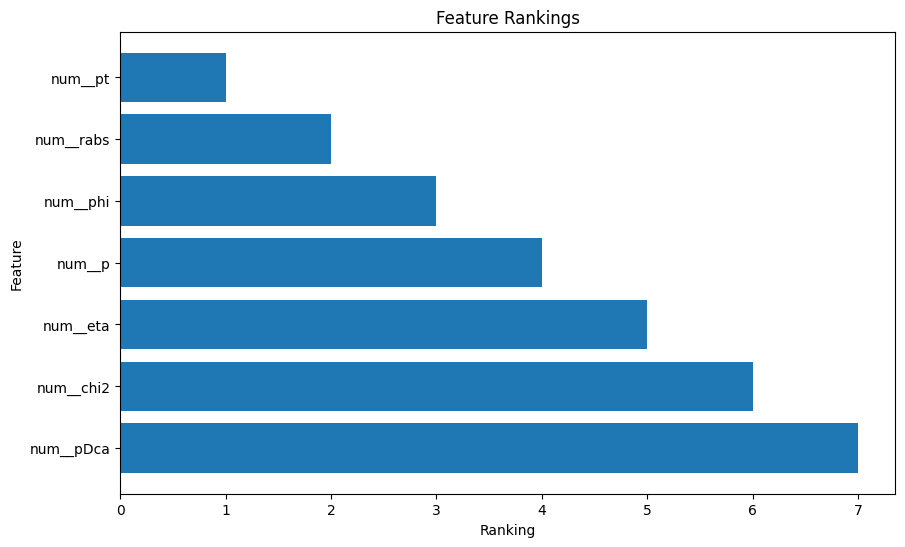

In [495]:
#Feature ranking using verbatim the tree method we did with the previous model

# Initialize the Random Forest model
model = sklearn.ensemble.RandomForestClassifier(n_estimators=100, random_state=42,class_weight=class_weight_dict)

# Initialize RFE
rfe = sklearn.feature_selection.RFE(estimator=model, n_features_to_select=1)

# Fit RFE For some reason refuses to finish.
rfe.fit(x_train, y_train)

# Get the ranking of the features
ranking = rfe.ranking_
print(ranking)
print(X)
# Create a DataFrame for visualization
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Ranking': ranking
})

# Sort the DataFrame by ranking
feature_ranking = feature_ranking.sort_values(by='Ranking')

# Display the feature rankings
print("Feature rankings:")
print(feature_ranking)

# Plot the feature rankings
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking['Feature'], feature_ranking['Ranking'])
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.title('Feature Rankings')
plt.gca().invert_yaxis()
plt.show()


Feature importances:
     Feature  Importance
1    num__pt    0.202349
2     num__p    0.162159
6  num__rabs    0.135320
3   num__phi    0.132883
5  num__chi2    0.124961
0   num__eta    0.124216
4  num__pDca    0.118113


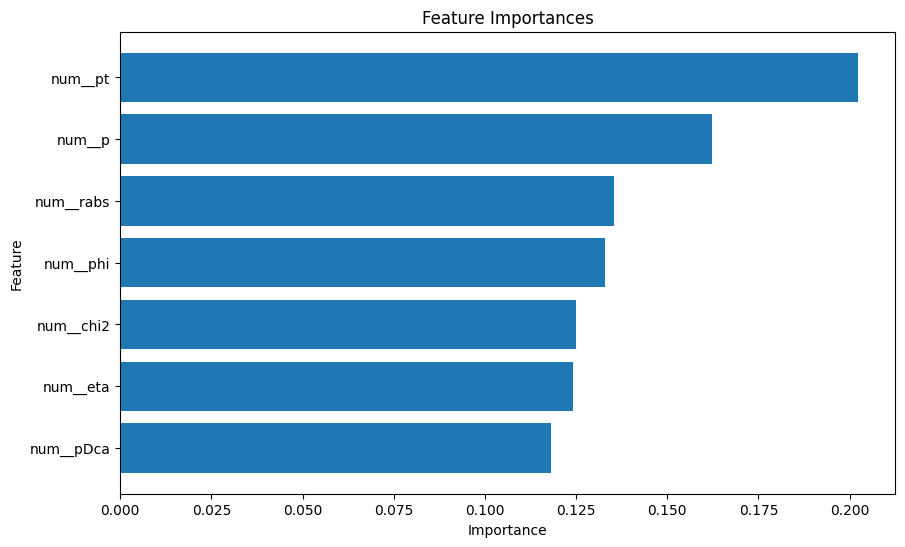

In [496]:
# Random forest Value of input parameters:
from sklearn.ensemble import RandomForestClassifier


# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight=class_weight_dict)

# Train the model
model.fit(x_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature importances:")
print(feature_importances)



plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Model Setup and Training

In [497]:
# model = Sequential([ # messing around with caleb's convolution
# Reshape((2,1)),
# Convolution1D(16,kernel_size=3, activation='relu', input_shape=(x_train.shape[1],), padding='same'), #N kernels fill
# Convolution1D(16,kernel_size=3, activation='relu',  padding='same'),
# Convolution1D(16,kernel_size=3,activation='relu',  padding='same'), Dropout(0.2),
# keras.layers.Flatten(),
# Dense(128, activation='relu'),
# Dense(1, activation='sigmoid') #softmax
# ])
model = Sequential([
Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(x_train.shape[1],)),
Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate= 0.0002), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 
history = model.fit(x_train,y_train,epochs=1000,batch_size=20,verbose=1,validation_split=0.2,shuffle=True, callbacks=[es],class_weight=class_weight_dict)

Epoch 1/1000


/home/zinhle/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4054 - loss: 0.7157 - val_accuracy: 0.4368 - val_loss: 0.7345
Epoch 2/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4308 - loss: 0.6946 - val_accuracy: 0.4838 - val_loss: 0.7254
Epoch 3/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4633 - loss: 0.6785 - val_accuracy: 0.5054 - val_loss: 0.7201
Epoch 4/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4914 - loss: 0.6662 - val_accuracy: 0.5126 - val_loss: 0.7160
Epoch 5/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5222 - loss: 0.6566 - val_accuracy: 0.5343 - val_loss: 0.7027
Epoch 6/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5367 - loss: 0.6489 - val_accuracy: 0.5271 - val_loss: 0.6984
Epoch 7/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5584 - loss: 0.6426 - val_accuracy: 0.5415 - val_loss: 0.6904
Epoch 8/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5647 - loss: 0.6372 - val_accuracy: 0.5523 - val_lo

# Model Evaluation

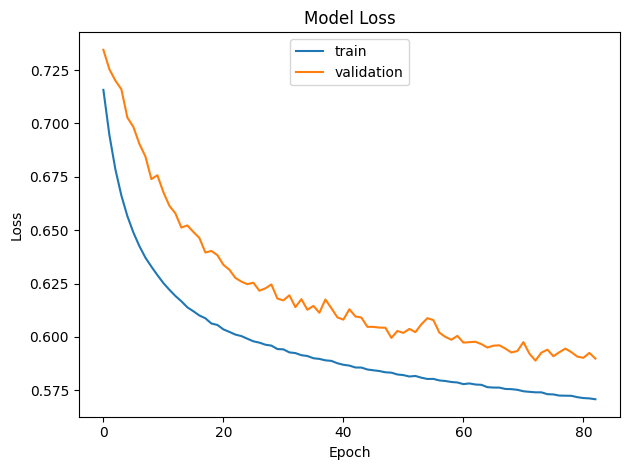

In [498]:
plt.plot(history.history['loss'],"-")
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper center')
plt.tight_layout()
plt.show()

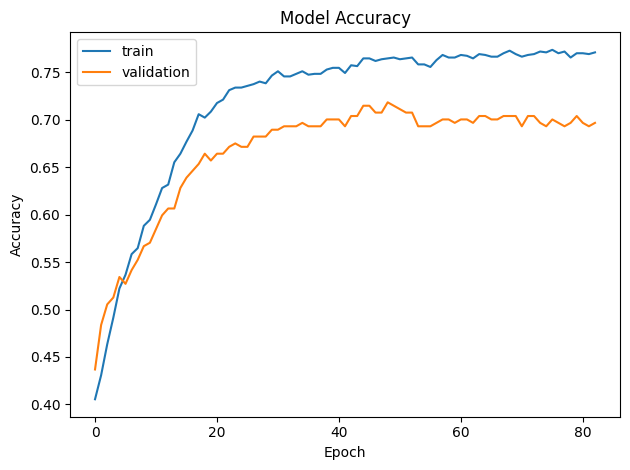

In [499]:
plt.plot(history.history['accuracy'],"-")
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([r'\bf{train}', r'\bf{validation}'],loc='best')
plt.legend(['train', 'validation'], loc='best')
plt.tight_layout()
plt.show()

In [500]:
pred_train= model.predict(x_train)
pred_train= list(chain.from_iterable(pred_train))

scores= model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))

pred_test= model.predict(x_test)
pred_test= list(chain.from_iterable(pred_test))

scoresS2 = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scoresS2[1], 1 - scoresS2[1]))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy on training data: 0.7568740844726562% 
 Error on training data: 0.24312591552734375
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy on test data: 0.7052023410797119% 
 Error on test data: 0.2947976589202881


In [501]:
# Function to retrieve model results
def function1(label, probs):
    # Convert label to a numpy array
    label = np.array(label)
    sig = []
    bkg = []
    for i in range(len(probs)):
        if label[i] == 1:
            sig.append(probs[i])
        elif label[i] == 0:
            bkg.append(probs[i])
    return sig, bkg

sig_training,bkg_training = function1(y_train, pred_train)
sig_testing,bkg_testing = function1(y_test, pred_test)

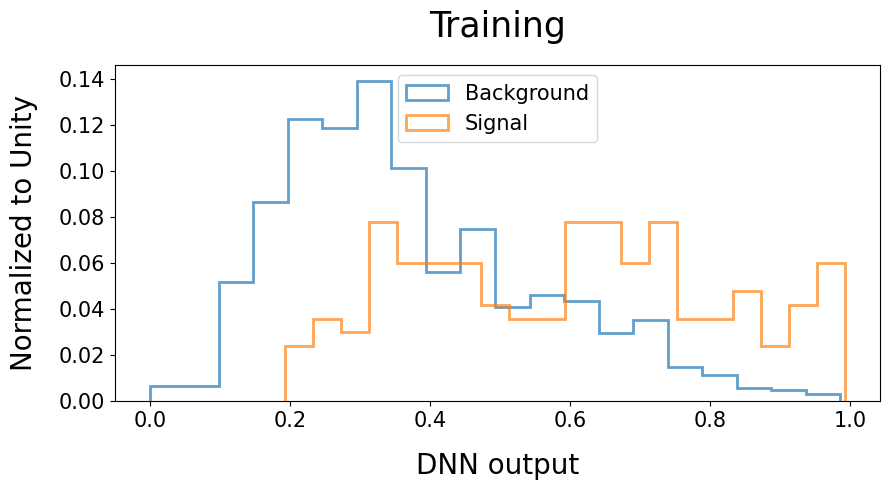

In [502]:
rng = np.random.default_rng(seed=123)

wei20 = np.ones_like(sig_training) / float(len(sig_training))
wei21 = np.ones_like(bkg_training) / float(len(bkg_training))

fig, ax = plt.subplots(figsize=(9,5))
ax.hist(bkg_training, weights=wei21, bins=20,  histtype='step', linewidth=2, alpha=0.7, label='Background')
ax.hist(sig_training, weights=wei20, bins=20,  histtype='step', linewidth=2, alpha=0.7, label='Signal')

# Add annotations
plt.ylabel('Normalized to Unity', fontsize=20, labelpad=15)
plt.xlabel('DNN output', fontsize=20, labelpad=15)
plt.title('Training', fontsize=25, pad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center')
plt.tight_layout()
plt.show()

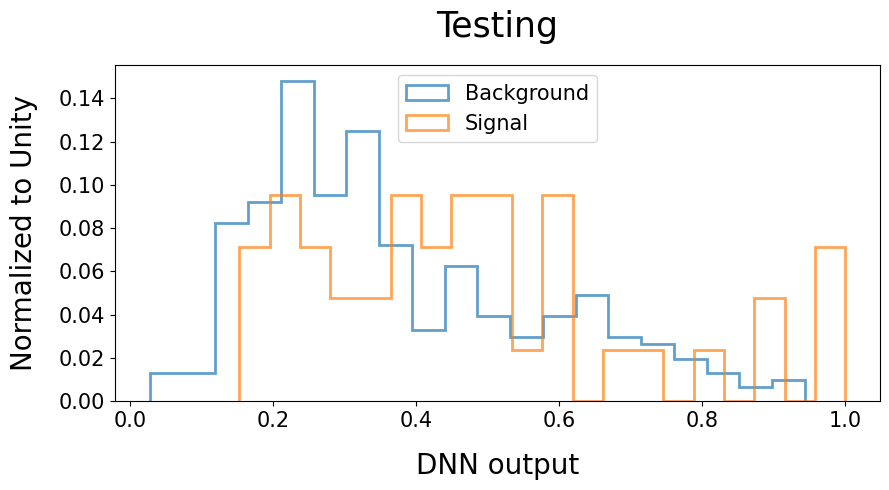

In [503]:
rng = np.random.default_rng(seed=123)

wei20t = np.ones_like(sig_testing) / float(len(sig_testing))
wei21t = np.ones_like(bkg_testing) / float(len(bkg_testing))

fig, ax = plt.subplots(figsize=(9,5))
ax.hist(bkg_testing, weights=wei21t, bins=20, histtype='step', linewidth=2, alpha=0.7, label='Background')
ax.hist(sig_testing, weights=wei20t, bins=20, histtype='step', linewidth=2, alpha=0.7, label='Signal')

# Add annotations
plt.ylabel('Normalized to Unity', fontsize=20, labelpad=15)
plt.xlabel('DNN output', fontsize=20, labelpad=15)
plt.title('Testing', fontsize=25, pad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center')
plt.tight_layout()
plt.show()

In [504]:
fpr_Test, tpr_Test, threshold = roc_curve(y_test, pred_test)
fpr_Train, tpr_Train, threshold = roc_curve(y_train, pred_train)

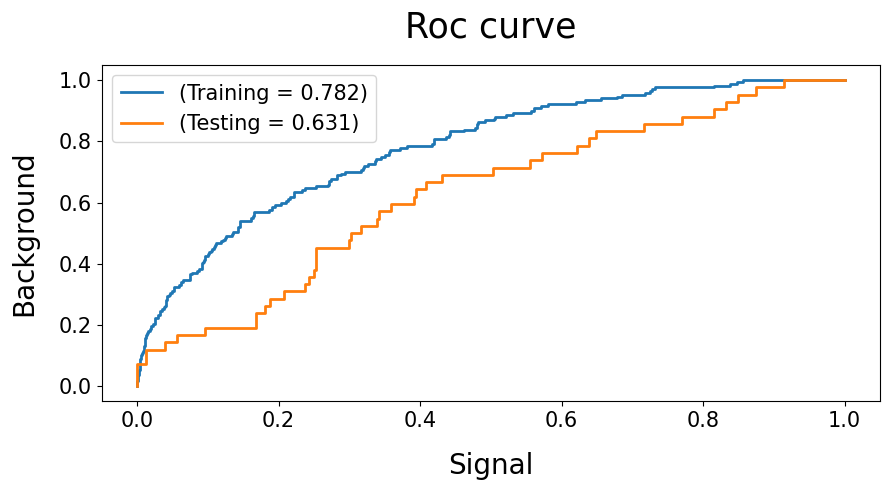

In [505]:

auc_keras_Test = auc(fpr_Test, tpr_Test)
auc_keras_Train = auc(fpr_Train, tpr_Train)

fig, ax = plt.subplots(figsize=(9,5))


ax.plot(fpr_Train, tpr_Train,linewidth=2, label='(Training = {:.3f})'.format(auc(fpr_Train, tpr_Train)))
ax.plot(fpr_Test, tpr_Test,linewidth=2, label='(Testing = {:.3f})'.format(auc(fpr_Test, tpr_Test)))

# Add annotations
plt.ylabel('Background', fontsize=20, labelpad=15)
plt.xlabel('Signal', fontsize=20, labelpad=15)
plt.title('Roc curve', fontsize=25, pad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()

plt.show()

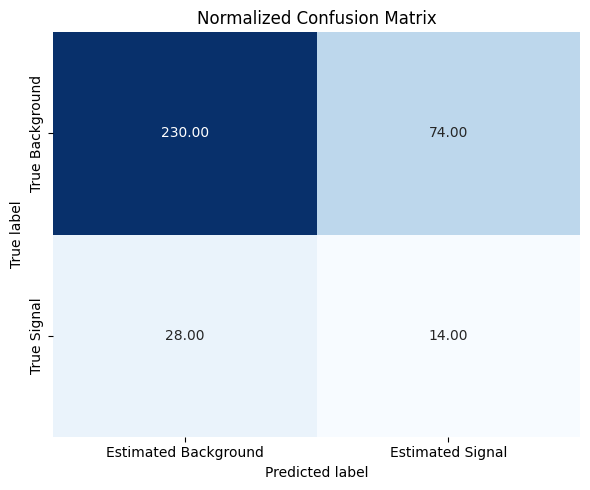

              precision    recall  f1-score   support

  Background       0.89      0.76      0.82       304
      Signal       0.16      0.33      0.22        42

    accuracy                           0.71       346
   macro avg       0.53      0.54      0.52       346
weighted avg       0.80      0.71      0.75       346



In [506]:
pred_test_int = (np.array(pred_test)>0.5).astype(int)
cm = confusion_matrix(y_test, pred_test_int)#,normalize='True'
# sns.heatmap(cm, annot=True)



plt.figure(figsize=(6,5))
ax = sns.heatmap(
    cm,
    annot=True, fmt=".2f", cmap="Blues", cbar=False,
    xticklabels=["Estimated Background", "Estimated Signal"],
    yticklabels=["True Background", "True Signal"]
)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


print(classification_report(y_test, pred_test_int, target_names=['Background','Signal']))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


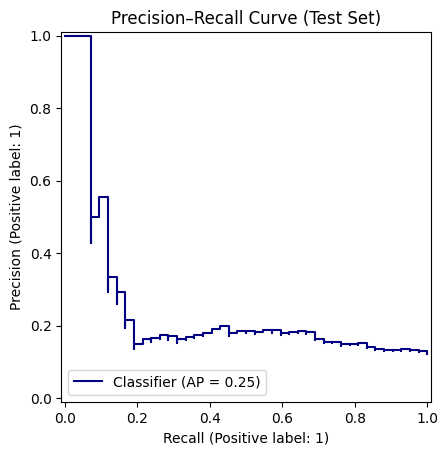

In [507]:
# Add precision vs recall graphs as well for unbalanced quality control
# Predict probabilities on the test set
y_pred_proba = model.predict(x_test)  # predicted probability for positive class

# Compute precision, recall, thresholds
# Predict probabilities on the test set

# Average precision (area under PR curve)
avg_prec = average_precision_score(y_test, y_pred_proba)

# Create and plot Precision–Recall display
disp = PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba,
    # name=f"NN (AP={avg_prec:.3f})",
    color="navy"
)
disp.ax_.set_title("Precision–Recall Curve (Test Set)")
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


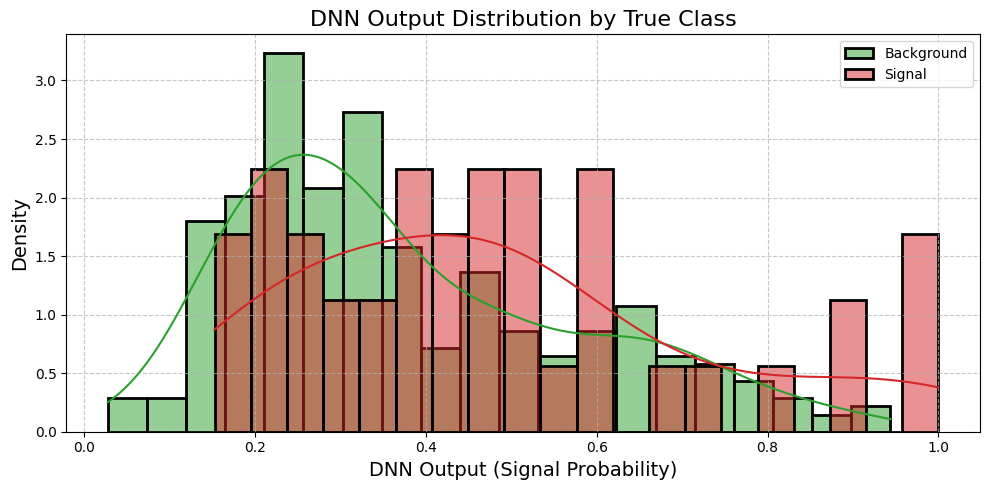

In [508]:
# Plotting code as dictated by the slides with no alterations

# Predicted probabilities
y_probs = model.predict(x_test).flatten()
y_preds = (y_probs > 0.5).astype(int)

# Class-wise score distribution using seaborn
plt.figure(figsize=(10, 5))
sns.histplot(y_probs[y_test == 0], bins=20, kde=True, label='Background',
color='tab:green', stat='density', linewidth=2)
sns.histplot(y_probs[y_test == 1], bins=20, kde=True, label='Signal',
color='tab:red', stat='density', linewidth=2)
plt.xlabel('DNN Output (Signal Probability)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('DNN Output Distribution by True Class', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Interactive scatter plot with hover info
fig = go.Figure()
fig.add_trace(go.Scatter(
y=y_probs,
mode='markers',
marker=dict(
size=8,
color=y_test, # True class color
colorscale='RdBu',
showscale=True,
colorbar=dict(title="True Label")
),
text=[f"True: {yt}, Pred: {yp:.2f}, xDat: {xt}" for xt, yt, yp in zip(x_test, y_test, y_probs)],
hoverinfo='text',
name='Predicted Probabilities'
))
fig.update_layout(
title="Interactive DNN Output: Predicted Signal Probabilities",
xaxis_title="Sample Index",
yaxis_title="DNN Output (Probability of Signal)",
template="plotly_white",
height=500
)
fig.show()